In [4]:
from pathlib import Path
import os
import pandas as pd
import torch as tc
import torchvision as tv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary as ts
import numpy as np

In [5]:
input_file = Path(r"C:/Users/Michał/Documents/SI/resources/beer_labels.zip") # Path to the "beer_labels.zip"
output_folder = Path(r"C:/Users/Michał/Documents/SI/workdir/beer_labels") # Path to the folder where to unzip the input ".zip" file

os.chdir(output_folder)

dirs = [d for d in os.listdir() if os.path.isdir(d)]

# for i, dir_name in enumerate(dirs):
#     os.rename(dir_name, str(i))

print(f"Input file path: {input_file}")
print(f"Output folder path: {output_folder}")

dataset_path = Path("C:/Users/Michał/Documents/SI/workdir/")
training_csv_path = os.path.join(dataset_path, "training.csv")
validation_csv_path = os.path.join(dataset_path, "validation.csv")
testing_csv_path = os.path.join(dataset_path, "testing.csv")

classes = []
for name in os.listdir(output_folder):
    if os.path.isdir(os.path.join(output_folder, name)):
        classes.append(name)

print(classes)

Input file path: C:\Users\Michał\Documents\SI\resources\beer_labels.zip
Output folder path: C:\Users\Michał\Documents\SI\workdir\beer_labels
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [6]:
all_cases = []

for current_class in classes:
    class_path = os.path.join(output_folder, current_class)
    image_files = os.listdir(class_path)

    for i in range(len(image_files)):
        image_path = os.path.join(class_path, image_files[i])
        all_cases.append((image_path,  current_class))
      
train_cases, test_cases = train_test_split(all_cases, test_size=0.2, random_state=42)
train_cases, val_cases = train_test_split(train_cases, test_size=0.125, random_state=42)

train_df = pd.DataFrame(train_cases, columns=["image_path", "image_class_name"])
train_df.to_csv(training_csv_path)

val_df = pd.DataFrame(val_cases, columns=["image_path", "image_class_name"])
val_df.to_csv(validation_csv_path)

test_df = pd.DataFrame(test_cases, columns=["image_path", "image_class_name"])
test_df.to_csv(testing_csv_path)


In [7]:
class BeerDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataframe = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.at[idx, 'image_path']
        current_image = tv.io.read_image(image_path)
        current_class = self.dataframe.at[idx, 'image_class_name']

        current_image = tv.transforms.functional.resize(current_image, (224,224), antialias=True)
        current_image = current_image.float() / 255.0
        current_image = (current_image - 0.5) / 0.5
        
        return current_image, current_class

In [8]:
batch_size = 16
shuffle = True
training_dataset = BeerDataset(os.path.join(dataset_path, "Training"), training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

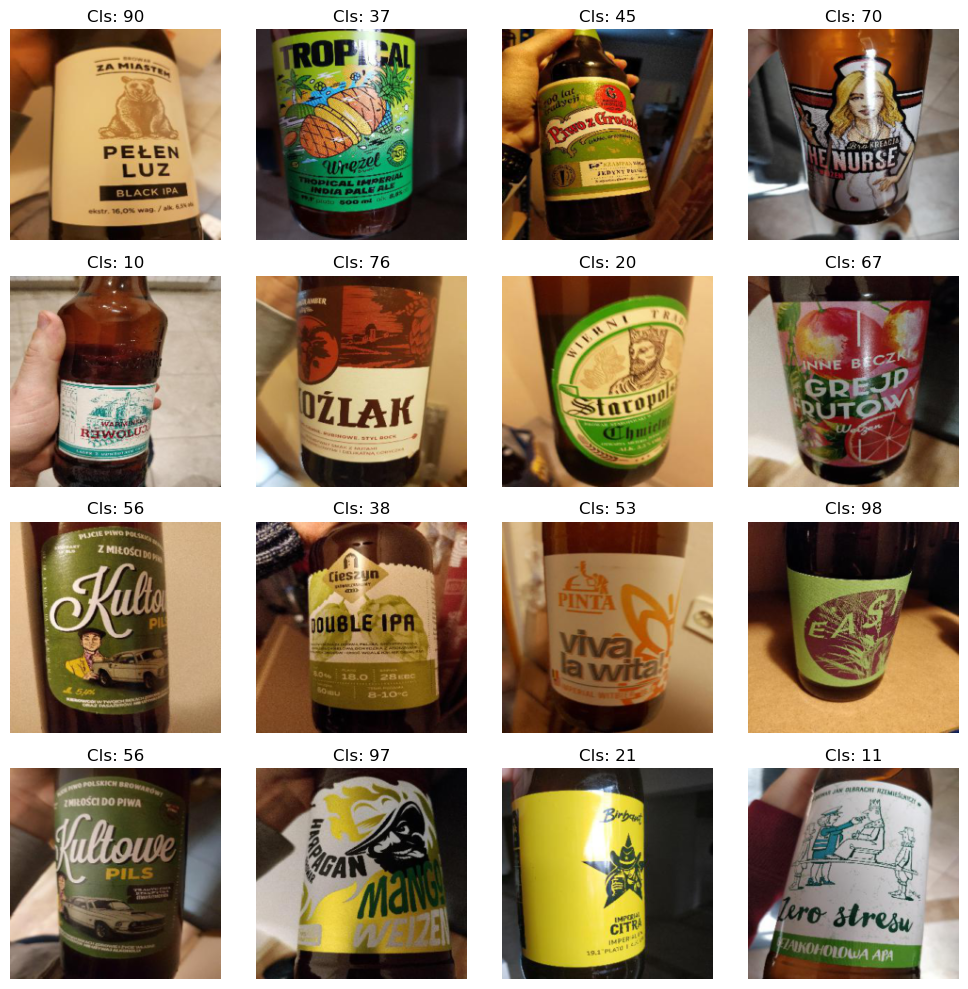

In [9]:
for images, classes in training_dataloader:
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        image = np.transpose(images[i].numpy(), (1, 2, 0))
        image = (image + 1) / 2
        ax.set_title("Cls: " + str(classes[i].item()))
        ax.imshow(image)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    break

In [10]:
class ClassificationNetwork(tc.nn.Module):
    def __init__(self):
        super(ClassificationNetwork, self).__init__()
        self.cnn = tc.nn.Sequential(
            tc.nn.Conv2d(3, 32, 3, 1, 1),
            tc.nn.BatchNorm2d(32),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1,1))
        )
        self.nn = tc.nn.Sequential(
            tc.nn.Linear(32, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, 100)  # change output classes = 100
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.nn(x)
        return x

In [11]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
#device = "cpu"

print("Device: " + device)

classification_network = ClassificationNetwork()

batch_size = 4
random_input = tc.randn((batch_size, 3, 224, 224))
random_output = classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
ts(classification_network.to(device), (3, 224, 224))

Device: cuda:0
Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 100])
Random output: 
tensor([[ 0.0036,  0.1036, -0.0100,  0.0127,  0.0392,  0.0084,  0.0237,  0.0476,
          0.0205, -0.1814,  0.0010, -0.0042, -0.0740,  0.0557,  0.1387, -0.0248,
         -0.1253,  0.0597, -0.0270, -0.0165, -0.0145,  0.0726,  0.0553, -0.1811,
          0.0702,  0.0336,  0.0405, -0.0489,  0.1021,  0.0683, -0.1179, -0.0394,
          0.0948,  0.0873, -0.0115,  0.1035, -0.0851,  0.0751, -0.0562, -0.0631,
         -0.0303, -0.1368,  0.0590, -0.0411, -0.1361, -0.0747, -0.0732,  0.0573,
         -0.0747,  0.0650, -0.0747, -0.0412,  0.1184, -0.0942, -0.2206, -0.0376,
          0.0243,  0.1018,  0.0902, -0.1247, -0.0730, -0.1182, -0.0069,  0.0176,
          0.0705, -0.0101,  0.1129, -0.0424, -0.1354, -0.0728, -0.0137, -0.1282,
          0.1238,  0.0380,  0.0943,  0.0366, -0.1222,  0.0893,  0.0208, -0.0603,
          0.0223, -0.1067,  0.0137,  0.0333, -0.0794,  0

In [12]:
class ImprovedClassificationNetwork(tc.nn.Module):
    def __init__(self):
        super(ImprovedClassificationNetwork, self).__init__()
        self.cnn = tc.nn.Sequential(
            tc.nn.Conv2d(3, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 128, 3, 2, 1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU(),
            tc.nn.Conv2d(128, 128, 3, 1, 1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU(),
            tc.nn.Conv2d(128, 256, 3, 2, 1),
            tc.nn.BatchNorm2d(256),
            tc.nn.ReLU(),
            tc.nn.Conv2d(256, 256, 3, 1, 1),
            tc.nn.BatchNorm2d(256),
            tc.nn.ReLU(),
            tc.nn.Conv2d(256, 512, 3, 2, 1),
            tc.nn.BatchNorm2d(512),
            tc.nn.ReLU(),
            tc.nn.Conv2d(512, 512, 3, 1, 1),
            tc.nn.BatchNorm2d(512),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1,1))
        )
        self.nn = tc.nn.Sequential(
            tc.nn.Linear(512, 512),
            tc.nn.BatchNorm1d(512),
            tc.nn.Dropout(0.5),
            tc.nn.ReLU(),
            tc.nn.Linear(512, 512),
            tc.nn.BatchNorm1d(512),
            tc.nn.Dropout(0.5),
            tc.nn.ReLU(),
            tc.nn.Linear(512, 100)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.nn(x)
        return x

In [13]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
print("Device: " + device)

improved_classification_network = ImprovedClassificationNetwork()
batch_size = 4
random_input = tc.randn((batch_size, 3, 224, 224))
random_output = improved_classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
ts(improved_classification_network.to(device), (3, 224, 224))

Device: cuda:0
Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 100])
Random output: 
tensor([[-6.3494e-01,  8.3567e-01,  7.0280e-02, -7.3150e-01,  2.6335e-01,
          3.7133e-01,  6.0016e-02,  7.1965e-01, -1.3761e-01, -9.5767e-01,
         -2.5328e-01,  3.0595e-01,  4.3885e-01, -4.3415e-01, -4.5371e-01,
         -9.2684e-01, -7.2960e-01, -3.2505e-01,  5.9295e-01, -9.9178e-01,
          5.6895e-01, -9.3284e-01,  2.6287e-01, -1.1381e-05,  3.6934e-02,
          1.1659e-01,  4.4600e-01,  1.0800e+00,  6.3064e-02,  1.1670e+00,
          7.1396e-01, -6.8894e-01,  3.4600e-01,  3.2446e-01,  3.1318e-01,
          6.0860e-01, -4.4654e-01,  4.3336e-01,  1.1275e+00, -1.2010e+00,
          1.0561e-01, -9.1273e-04,  6.7221e-01, -6.5401e-01, -6.6080e-02,
         -9.6269e-02, -4.3405e-01,  1.3153e-01, -3.6434e-01,  8.1036e-01,
         -2.2687e-01,  3.9960e-01,  1.8029e-01, -2.8767e-01,  4.2383e-02,
         -2.1292e-01, -2.5617e-01,  1.1168e+00,  4.5

In [14]:
def training(model, training_dataloader, testing_dataloader, num_epochs, learning_rate):
  
  objective_function = tc.nn.CrossEntropyLoss() 
  parameters = model.parameters() 
  optimizer = tc.optim.Adam(parameters, learning_rate) 
  device = "cuda:0" if tc.cuda.is_available() else "cpu" 
  #device = 'cpu'
  training_losses = []
  testing_losses = [] 
  model = model.to(device)
  
  print(f"Training dataset size: {len(training_dataloader.dataset)}")
  print(f"Testing dataset size: {len(testing_dataloader.dataset)}")
  for epoch in range(num_epochs):
    print(f"Current epoch: {epoch}")

    training_epoch_loss = 0.0
    model.train()
    for images, classes in training_dataloader:
        images, classes = images.to(device), classes.to(device) 
        output = model(images) 
        loss = objective_function(output, classes)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        training_epoch_loss += loss.item() * images.size(0)

    training_epoch_loss = training_epoch_loss / len(training_dataloader.dataset)
    training_losses.append(training_epoch_loss)
    print(f"Current epoch training loss: {training_epoch_loss}")

    testing_epoch_loss = 0.0
    model.eval()
    for images, classes in testing_dataloader:
      with tc.set_grad_enabled(False):
        images, classes = images.to(device), classes.to(device) 
        output = model(images) 
        loss = objective_function(output, classes)
        testing_epoch_loss += loss.item() * images.size(0)

    testing_epoch_loss = testing_epoch_loss / len(testing_dataloader.dataset)
    testing_losses.append(testing_epoch_loss)
    print(f"Current epoch testing loss: {testing_epoch_loss}")

  # Return the trained model and the history of training and testing losses
  return model, training_losses, testing_losses

In [15]:
learning_rate = 0.002
batch_size = 16
num_epochs = 5
shuffle = True
transforms = tc.nn.Sequential(
  tv.transforms.RandomRotation(20),
)

#Trainig dataset/dataloader
training_dataset = BeerDataset(os.path.join(dataset_path, "Training"), training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
# Validation dataset/dataloader
validation_dataset = BeerDataset(os.path.join(dataset_path, "Validation"), validation_csv_path)
validation_dataloader = tc.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
# Testing dataset/dataloader
testing_dataset = BeerDataset(os.path.join(dataset_path, "Testing"), testing_csv_path)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In [16]:
classification_model, training_losses, testing_losses = training(classification_network, training_dataloader, validation_dataloader, num_epochs, learning_rate)

Training dataset size: 5604
Testing dataset size: 801
Current epoch: 0
Current epoch training loss: 4.177794578328974
Current epoch testing loss: 3.625553329636839
Current epoch: 1
Current epoch training loss: 3.6006205153414217
Current epoch testing loss: 3.373074358917503
Current epoch: 2
Current epoch training loss: 3.4458138862735113
Current epoch testing loss: 3.2960894235808604
Current epoch: 3
Current epoch training loss: 3.2962771479697164
Current epoch testing loss: 3.130559790298138
Current epoch: 4
Current epoch training loss: 3.150659589066325
Current epoch testing loss: 2.898917102337479


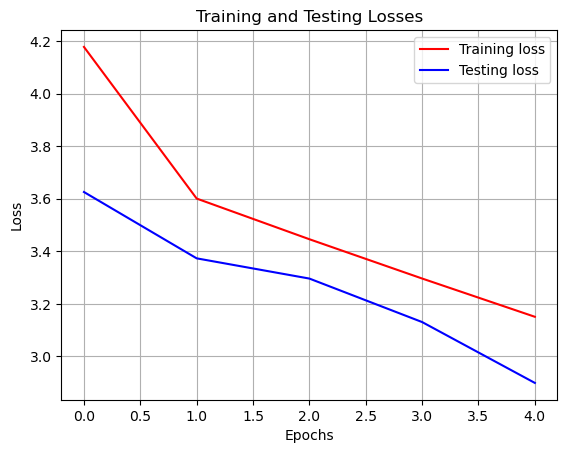

In [17]:
epochs = range(0, 5)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, testing_losses, 'b', label='Testing loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')

plt.grid()
plt.legend()
plt.show()

In [18]:
def accumulate_predictions(model, dataloader):
  predictions = []
  targets = []
  
  model.eval()
  with tc.set_grad_enabled(False):
      print(f"Dataset size: {len(dataloader.dataset)}")
      for images, classes in dataloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        pred = output.argmax(dim=1)

        predictions.append(pred.cpu())
        targets.append(classes.cpu())
  predictions = tc.cat(predictions)
  targets = tc.cat(targets)
  return predictions, targets

training_predictions, training_targets = accumulate_predictions(classification_model, training_dataloader)
testing_predictions, testing_targets =  accumulate_predictions(classification_model, testing_dataloader)

Dataset size: 5604
Dataset size: 1602


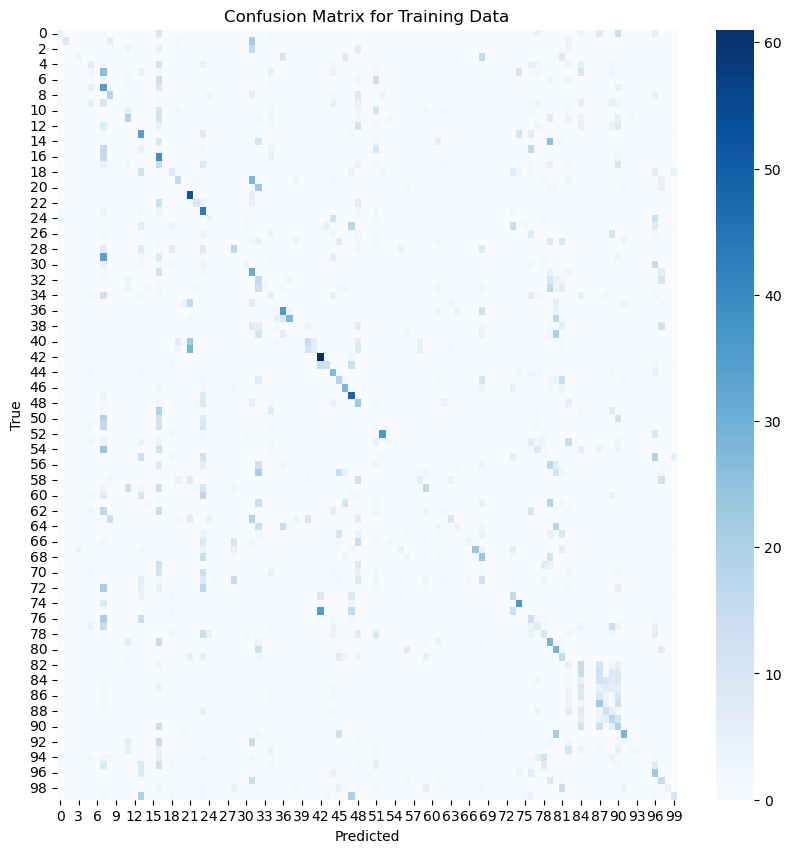

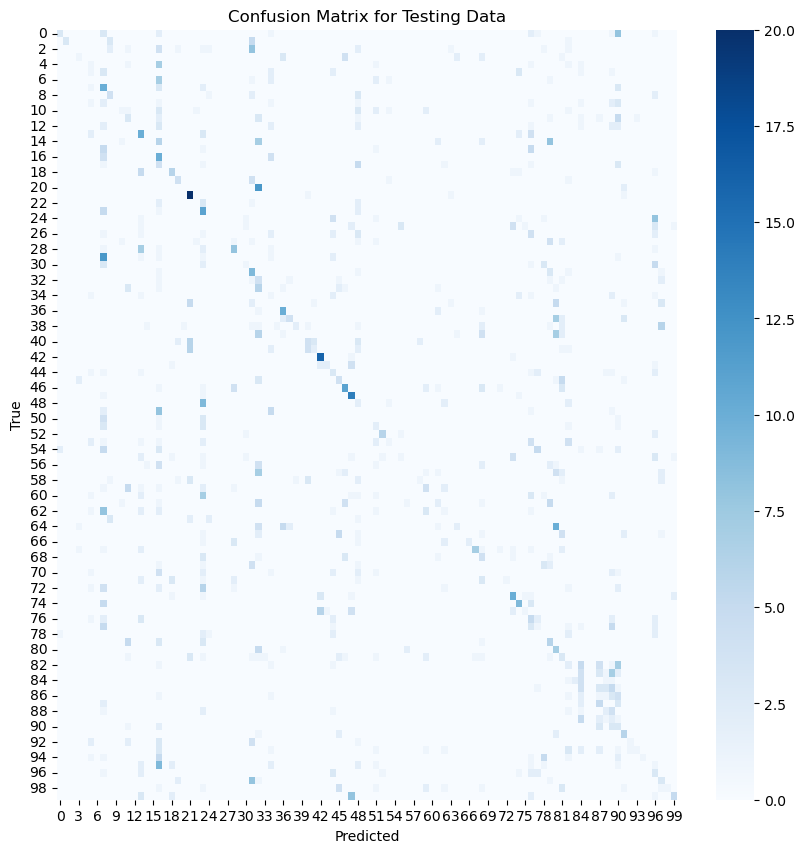

In [19]:
import sklearn.metrics as metrics
import seaborn as sns

#training_report = metrics.classification_report(training_targets, training_predictions, target_names=classes)
#testing_report = metrics.classification_report(testing_targets, testing_predictions, target_names=classes)

training_cm = metrics.confusion_matrix(training_targets, training_predictions)
testing_cm = metrics.confusion_matrix(testing_targets, testing_predictions)

#print(training_report)
#print(testing_report)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=training_cm)
# cm_display.plot()

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=testing_cm)
# cm_display.plot()

# Plot the confusion matrix for training data
fig, ax = plt.subplots(figsize=(10,10)) # adjust the figsize to fit your matrix size
sns.heatmap(training_cm, cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix for Training Data')

# Plot the confusion matrix for testing data
fig, ax = plt.subplots(figsize=(10,10)) # adjust the figsize to fit your matrix size
sns.heatmap(testing_cm, cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix for Testing Data')

plt.show()

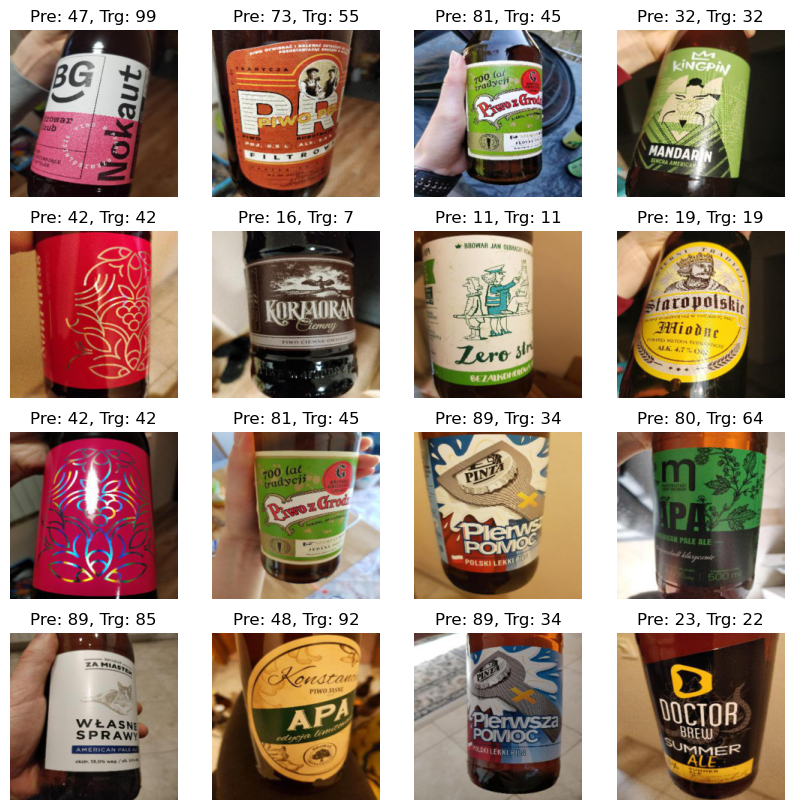

In [22]:
predictions = []
targets = []
  
with tc.set_grad_enabled(False):
  for images, classes in testing_dataloader:
    images2 = images.to(device)
    classes = classes.to(device)

    output = classification_model(images2)
    pred = output.argmax(dim=1)

    predictions.append(pred.cpu())
    targets.append(classes.cpu())

    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    axs = axs.ravel()
    for i in range(16):
      image = np.transpose(images[i].numpy(), (1, 2, 0))
      image = (image + 1) / 2
      axs[i].imshow(image)
      axs[i].set_title(f"Pre: {predictions[0][i]}, Trg: {targets[0][i]}")
      axs[i].axis('off')
    plt.show()
    break